## Importing modules

In [1]:
#Importing modules and font style
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
%matplotlib inline
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['lines.linewidth']=3
plt.rcParams['lines.markersize']=10

## Molar to debye length to kappa

In [2]:
# --> mM [2,5,10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200] 22

# --> Debye length (nm) [6.888204173817549, 4.356482835508365, 3.0804985551107635, 2.1782414177541827,1.7785266700314526,1.5402492775553818,1.3776408347635098,1.2576082689003694,1.1643190129881256
# , 1.0891207088770913,1.0268328517035876, 0.9741391763007738,  0.9288052613213044, 0.8892633350157263, 0.8543765764957377, 0.8232978695483315, 0.7953813067973331, 0.7701246387776909,
# 0.7471306424873098, 0.7260804725847274, 0.706714836707941, 0.6888204173817549]

# --> Kappa (1/nm) 	

# array([0.01451757, 0.0229543 , 0.03246228, 0.04590859, 0.05622631,
#        0.06492456, 0.07258786, 0.07951602, 0.08588711, 0.09181719,
#        0.09738683, 0.10265474, 0.1076652 , 0.11245263, 0.11704441,
#        0.12146272, 0.12572586, 0.12984911, 0.1338454 , 0.13772578,
#        0.14149979, 0.14517572])

molar_data = [2,5,10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200] 

kappa = np.array([0.01451757, 0.0229543 , 0.03246228, 0.04590859, 
        0.05622631, 0.06492456, 0.07258786, 0.07951602, 0.08588711, 
        0.09181719, 0.09738683, 0.10265474, 0.1076652 , 0.11245263, 
        0.11704441, 0.12146272, 0.12572586, 0.12984911, 0.1338454 , 
        0.13772578, 0.14149979, 0.14517572])

molar_to_kappa = dict(zip(molar_data, kappa))


## Functions 

In [3]:
def get_energy_data(results_file_path):
    """
    Read energy and distances from Pygbe results file, for 
    a afm-tip example
    -------
    Inputs:
        results_file_path: Pygbe results file
    Return:
        None
    """
    results_file = open(results_file_path,'r')
    results_data = results_file.read().split('\n')
    for line in results_data:
        if 'Surface 0' in line:
            surf = 0
        elif 'Surface 1' in line:
            surf = 1
        elif 'box center' in line:
            aux = line.split(': ')
            if surf == 0:
                line = aux[1].split(',')
                r_surf1 = np.array([float(line[0]),float(line[1]),float(line[2])])
            elif surf == 1:
                line = aux[1].split(',')
                r_surf2 = np.array([float(line[0]),float(line[1]),float(line[2])])
    aux = results_data[-6].split('= ')
    E_solv = float(aux[1].split(' ')[0])
    aux = results_data[-5].split('= ')
    E_surf = float(aux[1].split(' ')[0])
    aux = results_data[-4].split('= ')
    E_coul = float(aux[1].split(' ')[0])
    results_file.close()
    
    return r_surf1, r_surf2, E_solv, E_surf, E_coul

def readpqr(filename, N):
    """
    Read pqr-format file
    -------
    Inputs:
        filename: file .pqr with point-charge-radius format
        N: number of solute charges present in filename
    Return:
        position: Array size (Nx3) with charges positions
        q: Array size (Nx1) with charges values
        amino_acid_name: Array (Nx1) with charges amino acid name
        amino_acid_number: Array (Nx1) with charges amino acid name 
        atom_name: Array (Nx1) with atom_names
        atom_number: Array (Nx1) with atom_numbers  
    """
    pqr_file = open(filename,'r')
    position = np.zeros((N,3))
    q = np.zeros(N)
    amino_acid_name = np.array(q, dtype=np.string_)
    atom_name = np.array(q, dtype=np.string_)
    chain = np.array(q, dtype=np.string_)
    amino_acid_number = np.zeros(N, dtype=int)
    counter = 0
    for i, line in enumerate(pqr_file):
        line_split = line.split()
        if line_split[0] == 'ATOM':
            position[counter,0] = float(line_split[6])
            position[counter,1] = float(line_split[7])
            position[counter,2] = float(line_split[8])
            q[counter] = float(line_split[9])
            amino_acid_name[counter] = line_split[3]
            amino_acid_number[counter] = int(line_split[5])
            atom_name[counter] = line_split[2]
            chain[counter] = line_split[4]
            counter += 1
        
    return position, q, amino_acid_name, amino_acid_number, atom_name,chain

def compute_force_qf(dphi, q, units='kcal'):
    """
    Compute forces due solute charges in the solute
    from dphi.txt file and q charges array
    -------
    Inputs:
        dphi: file .pqr with point-charge-radius format
        q: number of solute charges present in filename
    Return:
        force: Array size (Nx3) with forces for solute charges
        force_magnitude: Array size (Nx1) with forces magnitude for solute charges 
        total_force: Array size (1x3) with total force due solute charges
        total_force_magnitude: Array (1x1) with total force magnitude
    """
    if units == 'kcal':
        factor = 4*np.pi*332.0636817823836 #1e-3*Na*1e10*(qe**2/(ep_vacc*4*numpy.pi*cal2J))
    elif units == 'kJ':
        factor = 4.184*4*np.pi*332.0636817823836
    elif units == 'pN':
        factor = 69.467*4*np.pi*332.0636817823836
        
    force = -np.transpose(np.transpose(dphi)*q)
    force_magnitude = np.sqrt(np.sum(force**2, axis=1))
    total_force = np.sum(force, axis=0)
    total_force_magnitude = np.sqrt(np.sum(total_force**2))

    return factor*force, factor*force_magnitude, factor*total_force, factor*total_force_magnitude

def compute_force_qf_zika(dir, units='kcal'):
    """
    Read from directory with results file to get 
    fixed charge forces for afm-zika case
    -------
    Inputs:
        dir: directory with results file
    Return:
        fqf: Array size (1x3) with total force due solute charges
        fqf_mag: Array (1x1) with total force magnitude
    """    
    fqf = np.zeros((len(dir),3))
    fqf_mag = np.zeros(len(dir))
    dist = np.zeros((len(dir)))
    for j in range(len(dir)):
        dist[j] = (dir[j].split('dist')[-1])
        dphir_file = glob.glob(dir[j] + '\*dphir.txt')
        dphir = np.loadtxt(dphir_file[0])
        _, q, _, _, _,_ = readpqr('pqr\\ZIKV_6CO8_aa_charge_vdw_addspace.pqr',len(dphir))
        _, _, fqf[j,:], fqf_mag[j] = compute_force_qf(dphir,q, units)

    return dist, fqf, fqf_mag

def get_boundary_forces(data_sim, molarity):
    """
    Extract boundary forces from pygbe results file
    -------
    Inputs:
        data_sim: dictionary with simulation data directory
        molarity: int value of molarity
    Return:
        fdb: Array size (3x1) with dielectric boundary force
        fib: Array size (3x1) with ionic boundary force
    """
    # Use the first distance (2 Ang) to search boundary forces
    files = glob.glob(data_sim[str(molarity)][0]+'\*')

    #Get only the bound files from files list
    files_bound = [file for file in files if 'Bound' in file.split('\\')[-1].split('_')[0]]
    files_bound = sorted(files_bound, key=lambda x: int(x.split('_')[-1].split('Plane')[0]))

    fdb, fib = np.zeros((len(files_bound),3)), np.zeros((len(files_bound),3))
    j = 0
    factor = 69.467*4*np.pi*332.0636817823836 #factor to convert to pN
    for file in files_bound:
        file_data = open(file,'r')
        file_data = file_data.read().split('\n')
        #Dielectric boundary force
        fdb[j,:] = factor*np.array(file_data[-4].split(' '),dtype=np.float64)
        #Ionic boundary force
        fib[j,:] = factor*np.array(file_data[-2].split(' '),dtype=np.float64)
        j += 1

    return fdb, fib

In [5]:
# Save in a dictionary all the folders from allSimsZikaAsItIs
data_sim = dict()
allSimsZikaAsItIs = glob.glob('allSimsZikaAsItIs/*')
sims = glob.glob('allSimsZikaAsItIs/sysBunch2/*')
for dir in allSimsZikaAsItIs:
    data_molarity = dict()
    molarity = dir.split('sysBunch')[1]
    data_sim[molarity] = glob.glob(dir+'/*')

#sort a data_sim dictionary by key value
data_sim = dict(sorted(data_sim.items(), key=lambda x: int(x[0])))
#sort data_sim value array by dist value
for key, value in data_sim.items():
    data_sim[key] = sorted(value, key=lambda x: int(x.split('dist')[-1]))

## Plot example

### Load simulation files

In [14]:
molar = '40'

dist,fqf,_ = compute_force_qf_zika(data_sim[molar], units='pN')
fdb, fib = get_boundary_forces(data_sim, molar)

# Binding force by substracting solvation force for capsid far away from tip
F_terms = fqf+fdb+fib - (fqf[-1]+fdb[-1]+fib[-1] )

# MVM fitting function (Podgornik et al. Nanoscale, 2015)
def forces_MVM(d,B,A=0,k=1/6.8):
    return (A*np.exp(-2*k*d)+B*np.exp(-k*d))/(1-np.exp(-2*k*d))

In [238]:
# plt.style.use('seaborn-poster')
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.size'] = 16
# plt.rcParams['xtick.labelsize']=16
# plt.rcParams['ytick.labelsize']=16
# plt.rcParams['lines.linewidth']=3
# plt.rcParams['lines.markersize']=10
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


### Plot Capsid-Sphere molaridad $= 40 mM$ 

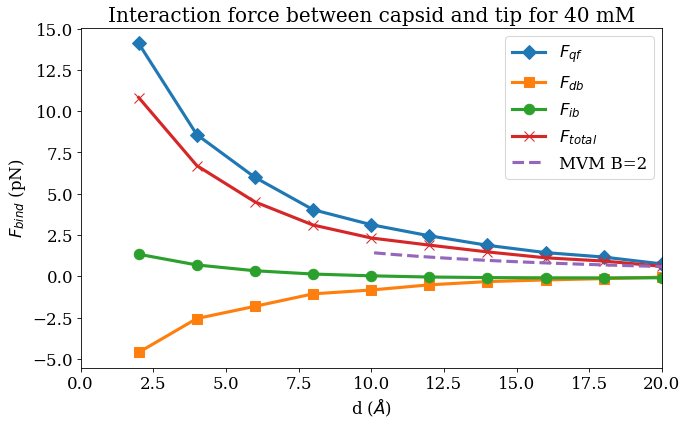

In [15]:
delta_fqf = (fqf.swapaxes(0,1)[0]-fqf.swapaxes(0,1)[0][-1])
delta_fdb = (fdb.swapaxes(0,1)[0]-fdb.swapaxes(0,1)[0][-1])
delta_fib = (fib.swapaxes(0,1)[0]-fib.swapaxes(0,1)[0][-1])
dd = np.arange(394,434,0.1)

plt.figure(figsize=(10,6),dpi=75)
plt.grid()
plt.plot(dist,-delta_fqf, marker='D',label='$F_{qf}$')
plt.plot(dist,-delta_fdb, marker='s',label='$F_{db}$')
plt.plot(dist,-delta_fib, marker='o',label='$F_{ib}$')
plt.plot(dist,-F_terms.swapaxes(0,1)[0], marker='x',label='$F_{total}$')
plt.plot(dd[1:]-384,forces_MVM(dd[1:]-384,2,k=molar_to_kappa[int(molar)]),label='MVM B=2',linestyle='--')
plt.grid()
plt.xlim([0,20])
plt.xlabel('d ($\AA$)');
plt.ylabel('$F_{bind}$ (pN)')
plt.legend()
plt.title('Interaction force between capsid and tip for %d mM' % int(molar))
plt.savefig('plots\\interaction_force_afmtip_%d(mM).png' % int(molar),dpi=150, bbox_inches='tight')
plt.show()
plt.close()


## Plot several molar values code

In [11]:
def plot_force_components(molar):

    dist,fqf,_ = compute_force_qf_zika(data_sim[molar], units='pN')
    fdb, fib = get_boundary_forces(data_sim, molar)

    # Binding force by substracting solvation force for capsid far away from tip
    F_terms = fqf+fdb+fib - (fqf[-1]+fdb[-1]+fib[-1] )

    delta_fqf = (fqf.swapaxes(0,1)[0]-fqf.swapaxes(0,1)[0][-1])
    delta_fdb = (fdb.swapaxes(0,1)[0]-fdb.swapaxes(0,1)[0][-1])
    delta_fib = (fib.swapaxes(0,1)[0]-fib.swapaxes(0,1)[0][-1])
    dd = np.arange(394,434,0.1)

    plt.figure(figsize=(10,6),dpi=75)
    plt.grid()
    plt.plot(dist,-delta_fqf, marker='D',label='$F_{qf}$')
    plt.plot(dist,-delta_fdb, marker='s',label='$F_{db}$')
    plt.plot(dist,-delta_fib, marker='o',label='$F_{ib}$')
    plt.plot(dist,-F_terms.swapaxes(0,1)[0], marker='x',label='$F_{total}$')
    plt.plot(dd[1:]-384,forces_MVM(dd[1:]-384,2,k=molar_to_kappa[int(molar)]),label='MVM B=2',linestyle='--')
    plt.grid()
    plt.xlim([0,20])
    plt.xlabel('d ($\AA$)');
    plt.ylabel('$F_{bind}$ (pN)')
    plt.legend()
    plt.title('Interaction force between capsid and plane for %d mM' % int(molar))
    plt.savefig('plots\\interaction_force_afmtip_%d(mM).png' % int(molar),dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

    return None

printing interaction force for 2 mM


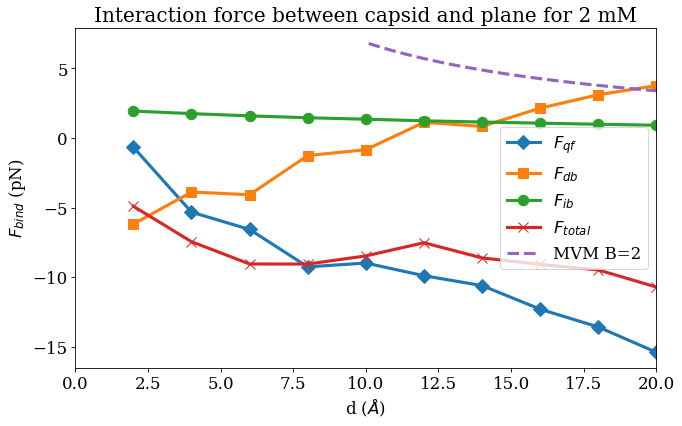

printing interaction force for 5 mM


KeyboardInterrupt: 

In [12]:
# Plotting al molar values detected in results folder
for molar in molar_data:
    if molar in [100,160]:
        continue
    print('printing interaction force for %d mM' % int(molar))
    plot_force_components(str(molar))

## Plot forces by distance and molarity (3d-plot)

In [10]:
molar_data[11:]

[100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

In [13]:
def forces_MVM(d,B,A=0,k=1/6.8):
    return (A*np.exp(-2*k*d)+B*np.exp(-k*d))/(1-np.exp(-2*k*d))

delta_fqf_all,delta_fdb_all,delta_fib_all, F_bindx_all = dict(), dict(), dict(), dict()

for molar in molar_data:
    if molar in [100,160]:
        continue
    molar = str(molar)
    print('calculating interaction force for %d mM' % int(molar))

    dist,fqf,_ = compute_force_qf_zika(data_sim[molar], units='pN')
    fdb, fib = get_boundary_forces(data_sim, molar)

    # Binding force by substracting solvation force for capsid far away from tip
    F_terms = fqf+fdb+fib - (fqf[-1]+fdb[-1]+fib[-1] )

    delta_fqf = (fqf.swapaxes(0,1)[0]-fqf.swapaxes(0,1)[0][-1])
    delta_fdb = (fdb.swapaxes(0,1)[0]-fdb.swapaxes(0,1)[0][-1])
    delta_fib = (fib.swapaxes(0,1)[0]-fib.swapaxes(0,1)[0][-1])
    F_bindx = F_terms.swapaxes(0,1)[0]

    delta_fqf_all[molar] = delta_fqf
    delta_fdb_all[molar] = delta_fdb
    delta_fib_all[molar] = delta_fib
    F_bindx_all[molar] = F_bindx
    


calculating interaction force for 2 mM
calculating interaction force for 5 mM
calculating interaction force for 10 mM
calculating interaction force for 20 mM
calculating interaction force for 30 mM
calculating interaction force for 40 mM
calculating interaction force for 50 mM
calculating interaction force for 60 mM
calculating interaction force for 70 mM
calculating interaction force for 80 mM
calculating interaction force for 90 mM
calculating interaction force for 110 mM
calculating interaction force for 120 mM
calculating interaction force for 130 mM
calculating interaction force for 140 mM
calculating interaction force for 150 mM
calculating interaction force for 170 mM
calculating interaction force for 180 mM
calculating interaction force for 190 mM
calculating interaction force for 200 mM


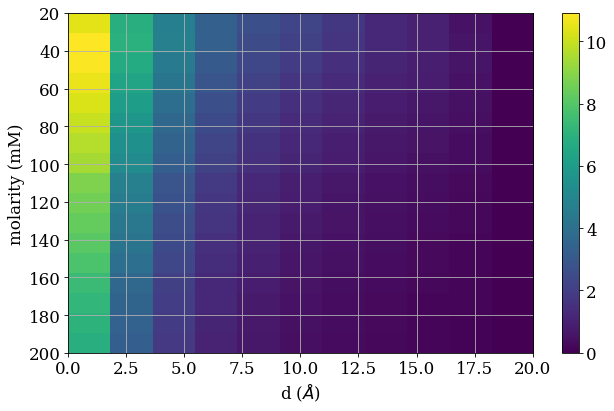

In [65]:
# Concatenate Fbinx
F_bindx_plot = np.concatenate((F_bindx_all['20'][:,None],F_bindx_all['30'][:,None],F_bindx_all['40'][:,None],\
    F_bindx_all['50'][:,None],F_bindx_all['60'][:,None],F_bindx_all['70'][:,None],\
    F_bindx_all['80'][:,None],F_bindx_all['90'][:,None],F_bindx_all['110'][:,None],\
    F_bindx_all['120'][:,None],F_bindx_all['130'][:,None],F_bindx_all['140'][:,None],\
    F_bindx_all['150'][:,None],F_bindx_all['170'][:,None],F_bindx_all['180'][:,None],\
    F_bindx_all['190'][:,None],F_bindx_all['200'][:,None]),axis=1)

# colorbar plot example
plt.figure(figsize=(10,6),dpi=75)
plt.grid()
plt.ylabel('molarity (mM)')
plt.imshow(-F_bindx_plot.T,aspect='auto',extent=[0,20,200,20])
plt.colorbar()
plt.xlabel('d ($\AA$)');
plt.show()

In [78]:
dist

array([   2.,    4.,    6.,    8.,   10.,   12.,   14.,   16.,   18.,
         20., 1000.])

In [84]:
y.shape

(17,)

In [119]:
def plot_3d_lines(force, term=None):

    if term not in ['qf','db','ib','bind']:
        print('Choose a term to plot')
        return None
    
    # Fbind x plot 3d
    fig = plt.figure(figsize=(22,22),dpi=75)
    ax = fig.add_subplot(projection='3d')

    # Plot a sin curve using the x and y axes.
    for molar in molar_data:
        if molar in [2,5,10,100,160]:
            continue
        x = np.linspace(0,20,11)
        y = molar*np.ones((11))
        if term == 'bind':
            ax.plot(x, y,zs=-F_bindx_all[str(molar)], zdir='z')
        elif term == 'qf':
            ax.plot(x, y,zs=-delta_fqf_all[str(molar)], zdir='z')
        elif term == 'db':
            ax.plot(x, y,zs=-delta_fdb_all[str(molar)], zdir='z')
        elif term == 'ib':
            ax.plot(x, y,zs=-delta_fib_all[str(molar)], zdir='z')

    ax.set_yticks([20,30,40,50,60,70,80,90,110,120,130,140,150,170,180,190,200])
    ax.set_xlabel('d ($\AA$)',labelpad=15)
    ax.set_ylabel('molarity (mM)',labelpad=15)
    ax.set_zlabel('$F_{%s}$ (pN)'%(term),labelpad=15)

    ax.view_init(elev=20., azim=-35)
    fig.savefig('plots_3d\\F_{%s}_afmtip_allmolar.png'%(term),dpi=150, bbox_inches='tight')


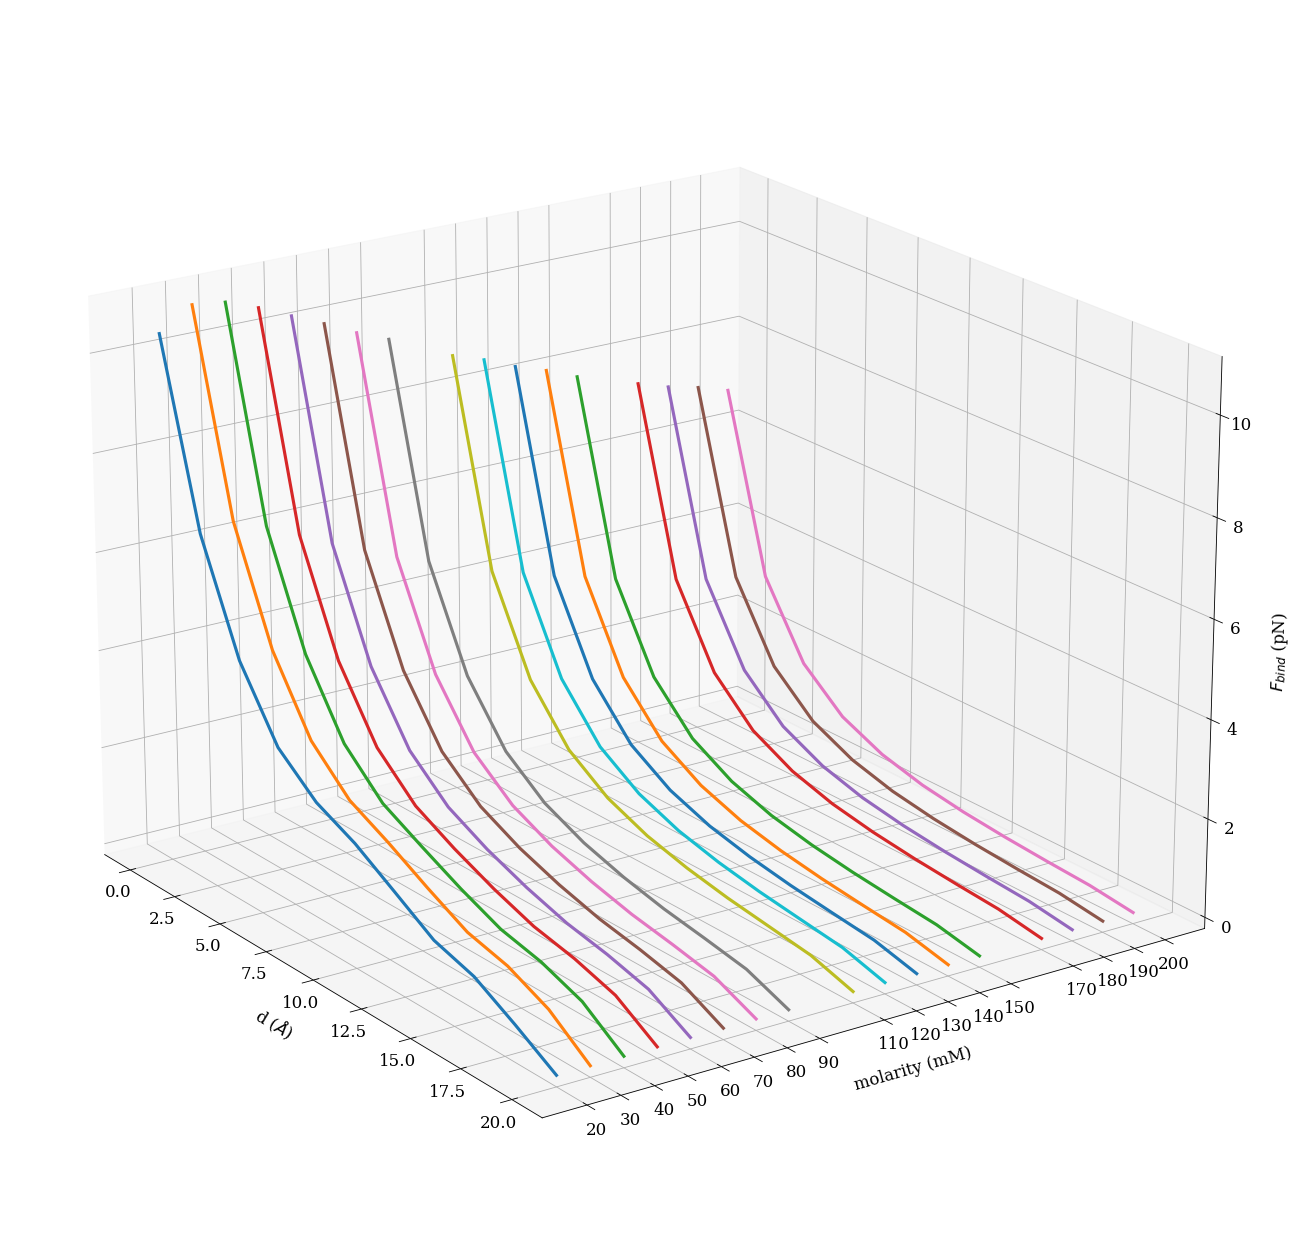

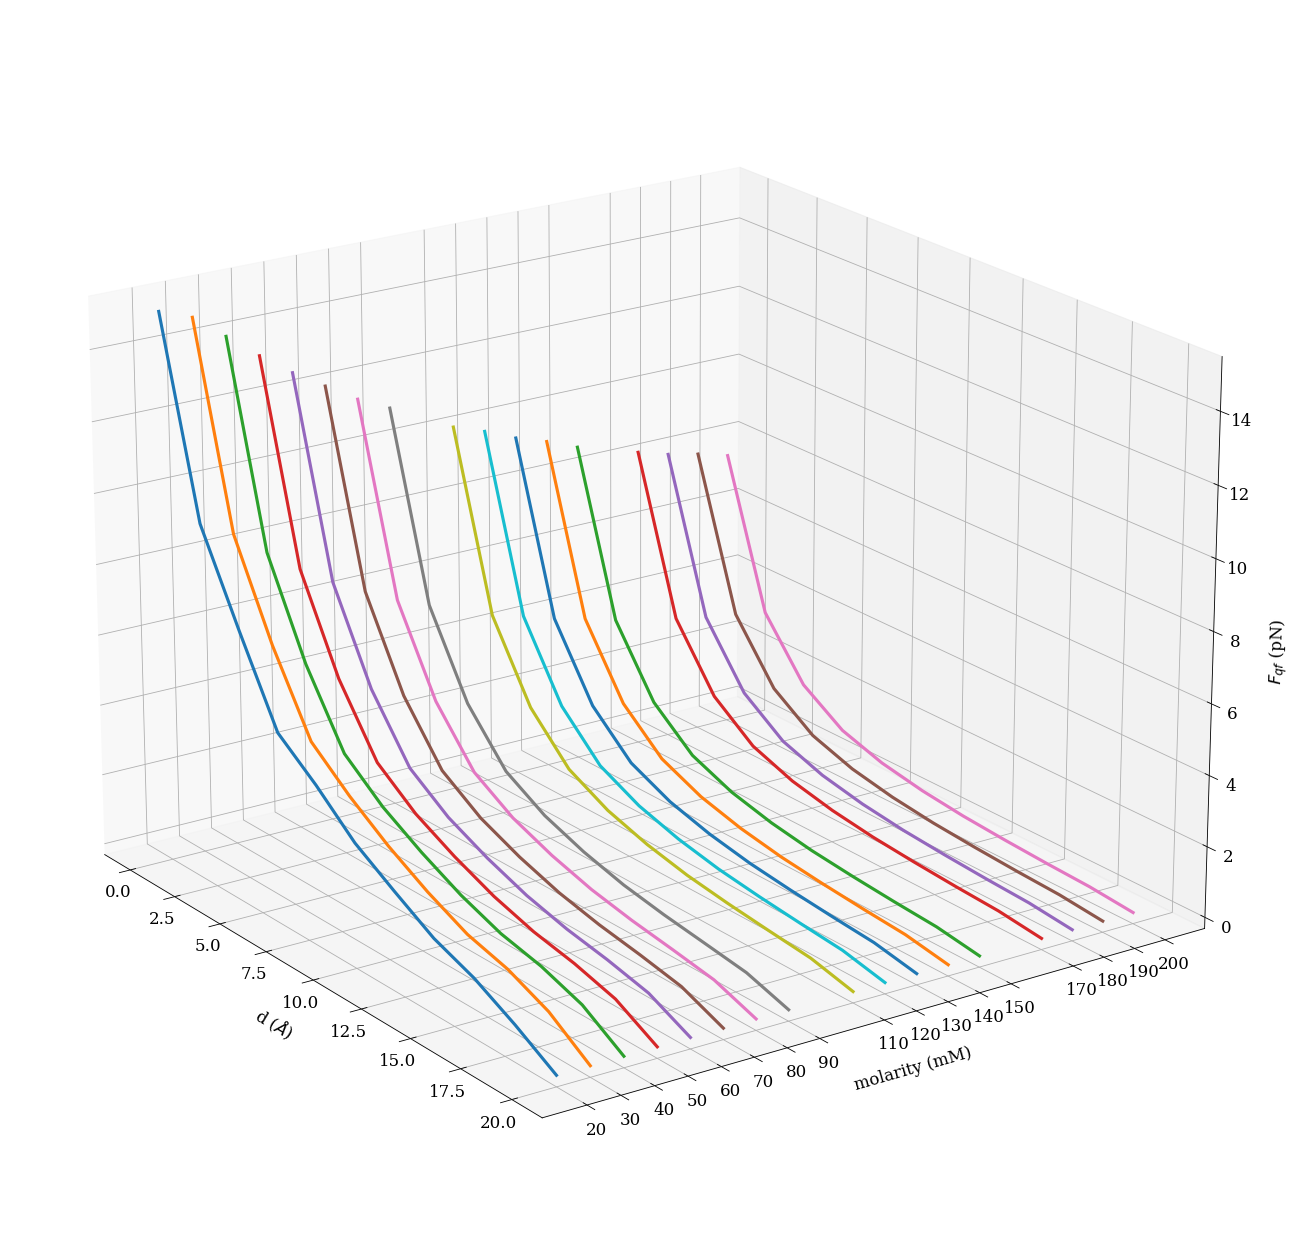

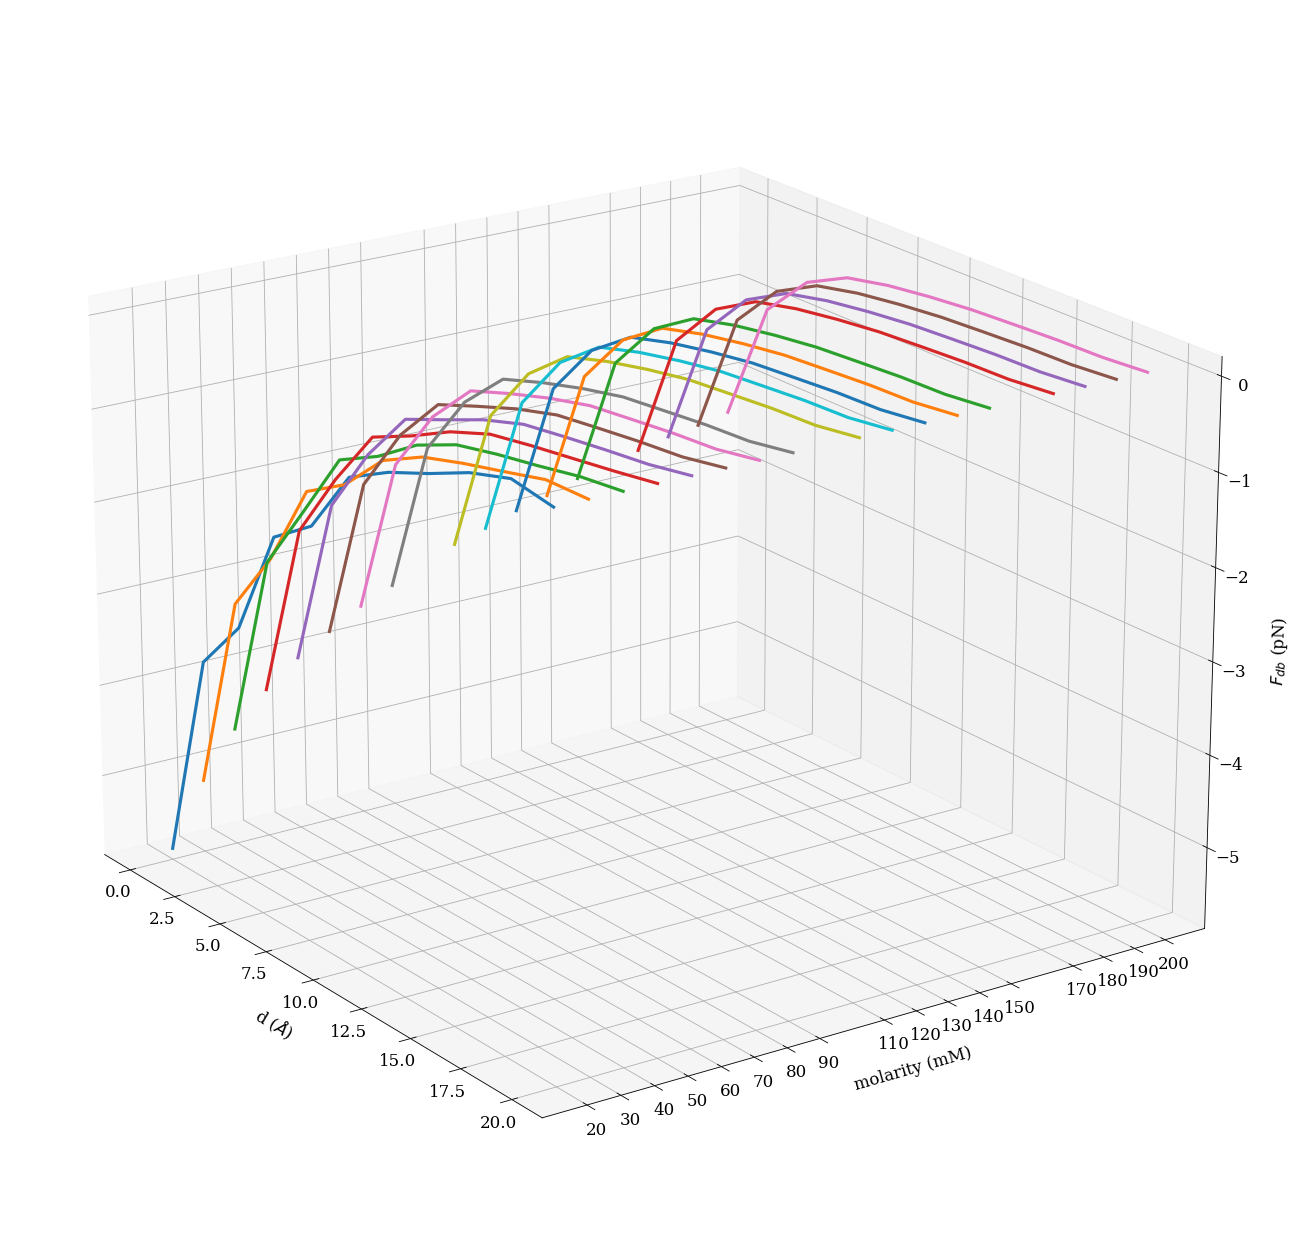

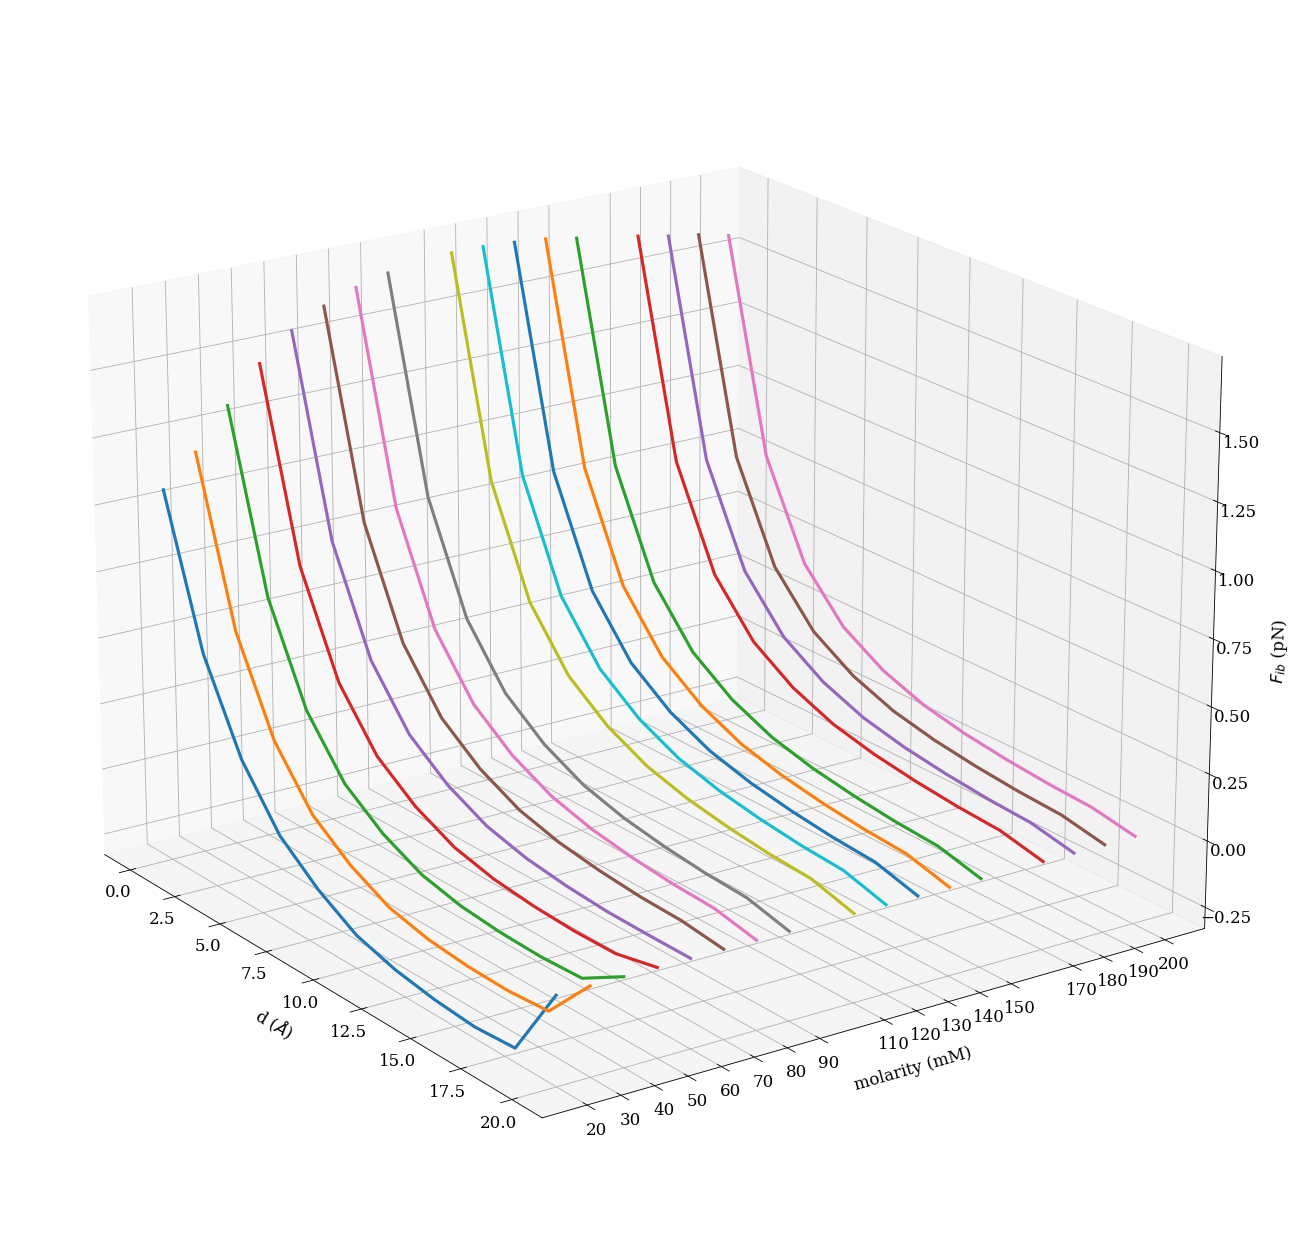

In [121]:
plot_3d_lines(F_bindx_all, term='bind')
plot_3d_lines(delta_fqf_all, term='qf')
plot_3d_lines(delta_fdb_all, term='db')
plot_3d_lines(delta_fib_all, term='ib')